# Sensitivity Map
Create a map which illustrates the sensitivity depending on its parameter space.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import utils
import ipywidgets as widgets
from IPython.display import display

# $\varepsilon$-$\sigma$ - plane
Let $\varepsilon = \mu - v$ be the error between the mean values $\mu$ and the ground truth $v$.

In [2]:
kidney = np.loadtxt('../../Data/kidney.csv', delimiter=',', skiprows=1, usecols=(0), dtype=np.float32).reshape((512,512))

#enforce to be zero on the edges
kidney[:,:10] = 50
kidney[:,-10:] = 50
kidney[:10,:] = 50
kidney[-10:,:] = 50

kidney = kidney[::8,::8]
img_shape = kidney.shape[0]

print(kidney.shape)

(64, 64)


In [3]:
algs = ['ramp', 'cosine', 'hamming', 'hann', 'shepp-logan', 'None']

means = np.zeros((len(algs),))
means_range = np.zeros((len(algs), 2))

error = np.zeros((len(algs),))
error_range = np.zeros((len(algs), 2))

variance = np.zeros((len(algs),))
variance_range = np.zeros((len(algs), 2))

width = 10
 
#input_range = 8649.794 # max - min value of sinogram
input_range = 1100
var = np.ones((64,64)) * input_range
Sigma_in = utils.build_covariance_y(var, function=utils.exponential, width=width)

for idx,alg in enumerate(algs):
    mu = np.load('../../Data/iradon/mu_'+alg+'.npy')
    means[idx] = np.mean(mu)
    means_range[idx,0] = np.min(mu)
    means_range[idx,1] = np.max(mu)
    epsilon = mu - kidney
    error[idx] = np.mean( epsilon )
    error_range[idx, 0] = error[idx] - np.min(epsilon)
    error_range[idx, 1] = np.max(epsilon) - error[idx]
    
    df_dx = np.load('../../Data/iradon/df_dx_'+alg+'.npy')
    Sigma = df_dx @ Sigma_in @ np.transpose(df_dx)
    sigma = np.reshape(np.abs(np.diag(Sigma)), mu.shape)
    
    variance[idx] = np.mean( sigma )
    variance_range[idx,0] = variance[idx] - np.min( sigma )
    variance_range[idx,1] = np.max( sigma ) - variance[idx]

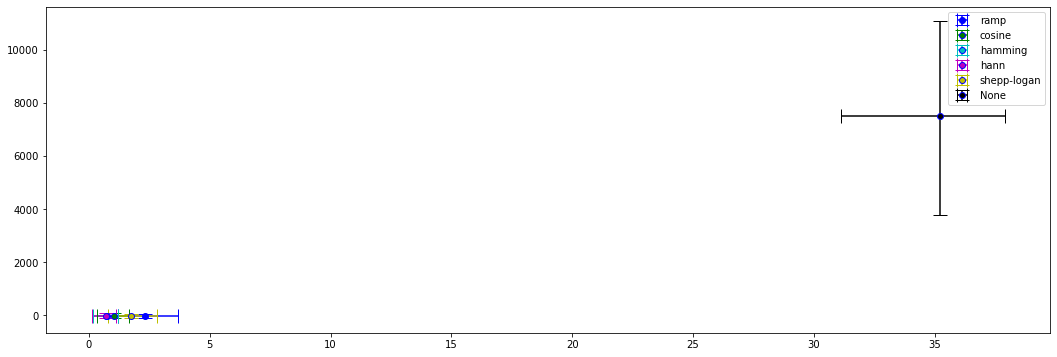

In [4]:
colors = ["b","g","c","m","y","k","r","g","c","m","y","k"]

plt.figure(figsize=(18,6))
i = 0
for e,e_r,v,v_r in zip(error, error_range, variance, variance_range):
    e_array = np.array([e])
    v_array = np.array([v])
    plt.errorbar(v_array, e_array, linestyle="None", mfc=colors[i], ecolor=colors[i], yerr=np.transpose([[e_r[0], e_r[1]]]), xerr=np.transpose([[np.sqrt(v_r[0]),np.sqrt(v_r[1])]]), fmt="ob", capsize=7, label=algs[i])
    i += 1
    
plt.legend()
plt.show()

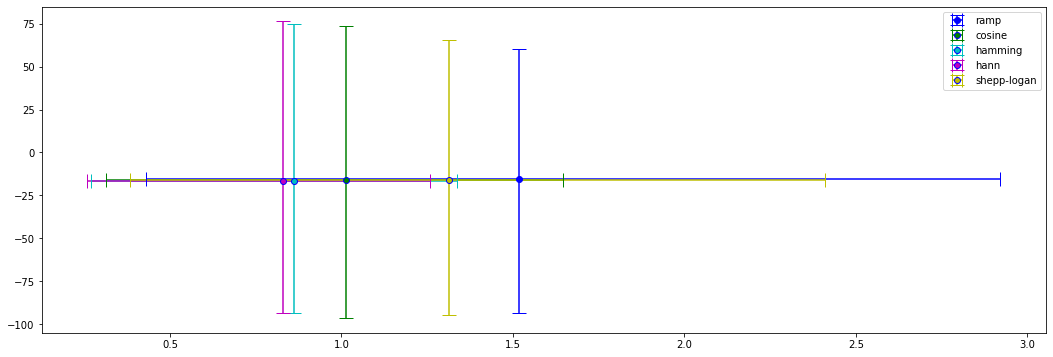

In [5]:
colors = ["b","g","c","m","y","k","r","g","c","m","y","k"]

plt.figure(figsize=(18,6))
i = 0
for e,e_r,v,v_r in zip(error[:-1], error_range[:-1], variance[:-1], variance_range[:-1]):
    e_array = np.array([e])
    v_array = np.array([np.sqrt(v)])
    v_range = [[np.sqrt(v_r[0]),np.sqrt(v_r[1])]]
    plt.errorbar(v_array, e_array, linestyle="None", mfc=colors[i], ecolor=colors[i], yerr=np.transpose([[e_r[0], e_r[1]]]), xerr=np.transpose(v_range), fmt="ob", capsize=7, label=algs[i])
    i += 1
    
plt.legend()
plt.show()

# 1D Wasserstein metric
Assume we have two random, normal distributed variables $X$\~$\mathcal{N}(\mu_x, \sigma_x^2)$ and $Y$\~$\mathcal{N}(\mu_y, \sigma_y^2)$ wich are different in their mean $\mu_x \neq \mu_y$ and variance $\sigma_x^2 \neq \sigma_y^2$. We can compute the wasserstein distance of both $W_2(X,Y) \geq 0$, which yelds no direction, wether one random variable is more certain than the other. We can enhance this by defining an additional poroperty of the increase of certainty $\zeta$: $\sigma_x \geq \sigma_y \rightarrow +W_2(X,Y)$, while $\sigma_x < \sigma_y \rightarrow -W_2(X,Y)$. Now we can define a unit-certainty $\zeta_0$, which just defines a basis for our space. This basis is a normal distribution with the mean $\mu_0 = 0$ and a variance $\sigma_0^2 = 1$. From this basis and the signed Wasserstein metric, we can build another metric to compare two random variables.

In [19]:
def wasserstein(mu1, var1, mu2, var2):
    return np.sqrt(
        ( mu1 - mu2 )**2 + ( np.sqrt(var1) - np.sqrt(var2) )**2
    )

def wasserstein_map(mu, var):
    w = wasserstein(0.0, 1.0, mu, var)
    w *= var - 1.0
    #w *= var
    #w *= 1.0 if var < 1.0 else -1.0
    return w

def normal_dist(x , mean , var):
    return 1 / np.sqrt(2*np.pi * var) * np.exp(-0.5*(x-mean)**2/var)

In [18]:
max_mu = 10.0
max_sigma = 6.0

def show_dist(m, var, max_mu=max_mu, max_sigma=max_sigma):
    mu = np.linspace(-0.5*max_mu, 0.5*max_mu)
    sigma = np.linspace(1e-9, max_sigma)

    mm, ss = np.meshgrid(mu, sigma)

    dist = wasserstein(0.0, 0.0, mm, ss)
    dist *= ss - 1.0
    #dist -= ss
    
    w = wasserstein(m, var, 0.0, 1.0)
    #w *= 1.0 if var < 1.0 else -1.0
    
    print(w * var - 1.0)

    plt.figure(figsize=(18,6))
    plt.imshow(dist, origin='lower')
    plt.colorbar()
    plt.scatter(m * 50/max_mu+25, var * 50/max_sigma, s=50, c='magenta')
    plt.xticks(np.linspace(0,50,5), np.linspace(-0.5*max_mu,0.5*max_mu,5))
    plt.yticks(np.linspace(0,50,5), np.linspace(0,max_sigma,5))
    plt.xlim(0,49)
    plt.ylim(0,49)
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$\sigma^2$')
    plt.show()
    
def show_pdfs(mu = 0.0, var = 0.1, max_mu=max_mu, max_sigma=max_sigma):
    space = np.linspace(-0.5*max_mu, 0.5*max_mu, 200)
    
    x = normal_dist(space, 0, 1.0)
    y = normal_dist(space, mu, var)
    
    plt.figure(figsize=(18,6))
    plt.plot(space, x, label='base')
    plt.plot(space, y, label='X')
    plt.legend()
    plt.xlim(-0.5*max_mu, 0.5*max_mu)
    plt.ylim(0,1.5)
    plt.show()
    
mu_widget = widgets.FloatSlider(
    value=3.0,
    min=-0.5*max_mu,
    max=0.5*max_mu,
    step=0.1,
    description=r'$\mu$:',
    layout=widgets.Layout(left='70px', width='395px')
)

var_widget = widgets.FloatSlider(
    value=0.1,
    min=0.1,
    max=max_sigma,
    step=0.1,
    orientation='vertical',
    description=r'$\sigma$:',
    layout=widgets.Layout(top='0px', height='405px')
)

mu_interact = widgets.interactive_output(show_dist, {
    'm': mu_widget,
    'var': var_widget
})

pdf_interact = widgets.interactive_output(show_pdfs, {
    'mu': mu_widget,
    'var': var_widget
})

layout = widgets.HBox([
    widgets.VBox([
        mu_widget,
        widgets.HBox([
            var_widget,
            mu_interact
        ])
    ])
])

display(widgets.VBox([
    layout,
    pdf_interact
]))

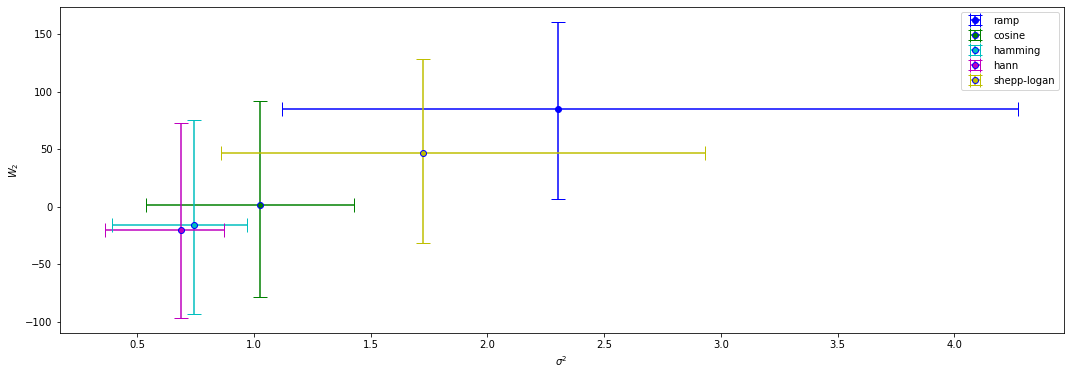

In [20]:
colors = ["b","g","c","m","y","k","r","g","c","m","y","k"]

plt.figure(figsize=(18,6))
i = 0
for m,e,e_r,v,v_r in zip(means[:-1], error[:-1], error_range[:-1], variance[:-1], variance_range[:-1]):
    e_array = np.array([wasserstein_map(m,v)])
    e_range = [[wasserstein_map(m,v_r[0]),wasserstein_map(m,v_r[1])]]
    v_array = np.array([v])
    v_range = [[v_r[0], v_r[1]]]
    plt.errorbar(v_array, e_array, linestyle="None", mfc=colors[i], ecolor=colors[i], yerr=np.transpose([[e_r[0], e_r[1]]]), xerr=np.transpose(v_range), fmt="ob", capsize=7, label=algs[i])
    i += 1
    
plt.legend()
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$W_2$')
plt.show()